conda install nomkl


http://scipy-cookbook.readthedocs.io/items/FittingData.html

http://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i

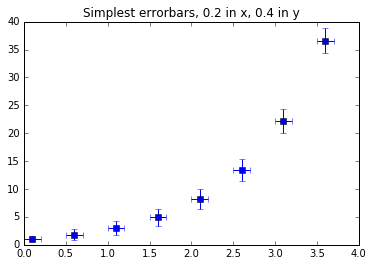

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

x = np.arange(0.1, 4, 0.5)
y = 1/np.exp(-x)
yerr = 0.01 + 1.2*np.sqrt(x)
xerr = 0.1 

plt.figure()
plt.errorbar(x, y, fmt="s", xerr=xerr, yerr=yerr)   #plt.plot(x, y, "bo-" )
plt.title("Simplest errorbars, 0.2 in x, 0.4 in y")

[ 1.37108421 -3.5679962   5.18497538]


<Container object of 3 artists>

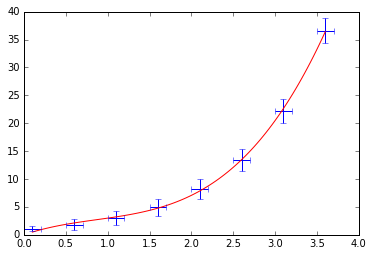

In [2]:
from scipy import optimize
fitfunc = lambda p, x: p[0]*x*x*x+p[1]*x*x+p[2]*x # Target function
#errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
def residuals(p,x,y):
    return abs(y-fitfunc(p,x))
p0 = [1.3, -3.6, 5.2 ] # Initial guess for the parameters
#NOWORK p1,pcov,infodict,errmsg,success=optimize.leastsq(errfunc,p0[:],args=(x, y),full_output=1,epsfcn=0.0001  )
#?p1,pcov,info,msg,ler=optimize.leastsq(residuals,p0,args=(x, y) , full_output=True )
p1,sim=optimize.leastsq(residuals,p0,args=(x, y)  )
#NONO p1,pcov=optimize.curve_fit(errfunc, x, y, p0, sigma=yerr, epsfcn=0.0001 )
print(p1)
time = np.linspace(x.min(), x.max(), 100)
plt.plot( time, fitfunc(p1, time) ,"r-" ) # Plot of the data and the fit
plt.errorbar(x, y, fmt="b ", xerr=xerr, yerr=yerr)   #plt.plot(x, y, "bo-" )

AGAIN EXACTLY THE EXAMPLES
==================================

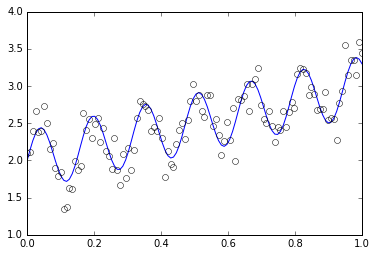

In [2]:
import numpy as np
from scipy import optimize
import random

def f( x, p0, p1, p2):
    return p0*x + 0.4*np.sin(p1*x) + p2

def ff(x, p):
    return f(x, *p)

# These are the true parameters
p0 = 1.0
p1 = 40
p2 = 2.0

# These are initial guesses for fits:
pstart = [
    p0 + random.random(),
    p1 + 5.*random.random(), 
    p2 + random.random()
]

%matplotlib inline
import matplotlib.pyplot as plt
xvals = np.linspace(0., 1, 120)
yvals = f(xvals, p0, p1, p2)

# Generate data with a bit of randomness
xdata = np.array(xvals)
np.random.seed(42)
err_stdev = 0.2
yvals_err =  np.random.normal(0., err_stdev, len(xdata))
ydata = f(xdata, p0, p1, p2) + yvals_err

plt.plot(xvals, yvals)
plt.plot(xdata, ydata, 'o', mfc='None')

In [ ]:
def fit_leastsq(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = \
        optimize.leastsq(errfunc, p0, args=(datax, datay), \
                          full_output=1, epsfcn=0.0001)

    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, perr_leastsq 

pfit, perr = fit_leastsq(pstart, xdata, ydata, ff)

print("\nFit paramters and parameter errors from lestsq method :")
print("pfit = ", pfit)
print("perr = ", perr)

In [ ]:
def fit_curvefit(p0, datax, datay, function, yerr=err_stdev, **kwargs):

    pfit, pcov = \
         optimize.curve_fit(f,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return pfit_curvefit, perr_curvefit 

pfit, perr = fit_curvefit(pstart, xdata, ydata, ff)

print("\nFit parameters and parameter errors from curve_fit method :")
print("pfit = ", pfit)
print("perr = ", perr)


In [3]:
def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):

    errfunc = lambda p, x, y: function(x,p) - y

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)


    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)

    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # 100 random data sets are generated and fitted
    ps = []
    for i in range(100):

        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomdataY = datay + randomDelta

        randomfit, randomcov = \
            optimize.leastsq(errfunc, p0, args=(datax, randomdataY),\
                             full_output=0)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 1. # 1sigma gets approximately the same as methods above
                # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * np.std(ps,0) 

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    return pfit_bootstrap, perr_bootstrap 

pfit, perr = fit_bootstrap(pstart, xdata, ydata, ff)

print("\nFit parameters and parameter errors from bootstrap method :")
print("pfit = ", pfit)
print("perr = ", perr)


Fit parameters and parameter errors from bootstrap method :
pfit =  [  1.04889392  39.95305958   1.95931802]
perr =  [ 0.05777306  0.1109414   0.03163813]
